In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from termcolor import colored
from torchvision import transforms
from net import *
from utils import *
from loss import *
warnings.filterwarnings('ignore')

In [4]:
def error_analysis(chunk_size):
    
    ## parameters
    img_root = "D:/nyc_taxi/data_min_max"
    mask_root = "D:/nyc_taxi/data_min_max"
    image_size = 64
    batch_size = 24
    test_imgs = np.load(img_root+'/test.npy')
    test_masks_random = np.load(mask_root+'/test_random_mask.npy')
    dataset_test = taxi_data(test_imgs, test_masks_random, image_size, chunk_size)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    
    ## load models
    model_l1 = PConvUNet(chunk_size=chunk_size).to(device)
    model_l1.load_state_dict(torch.load(f'model_states/biased_l1_{chunk_size}'))
    
    ## spatial error
    gt_total = torch.zeros((64,64))
    l1_spatial_error = torch.zeros((64,64))
    l1_sequential_error = []
    all_time_max = 1428
        
    for i in range(24, len(dataset_test), batch_size):
        ## get data
        indices = range(i, min(len(dataset_test), i+batch_size))
        mask, gt = zip(*[dataset_test[j] for j in indices])
        mask = torch.stack(mask).to(device)
        gt = torch.stack(gt).to(device)
        image = mask*gt
        
        ## modeling
        with torch.no_grad():
            output_l1, _ = model_l1(gt, mask)
        output_comp_l1 = mask * gt + (1 - mask) * output_l1
        
        ## scale back
        gt = (gt*all_time_max).cpu()
        output_comp_l1 = (output_comp_l1*all_time_max).cpu()
        
        ## compute errors on the last image
        gt = gt[:,0,-1,:,:]
        output_comp_l1 = output_comp_l1[:,0,-1,:,:]
        
        ## spatial error
        l1_spatial_error += torch.sum(output_comp_l1-gt, dim=0)
        
        ## sequential error
        l1_sequential_error += ((torch.sum(torch.sum(output_comp_l1-gt, dim=1),dim=1).numpy()/64).tolist())
        
    ## spatial error
    n = (len(dataset_test)-24)
    l1_spatial_error = l1_spatial_error/n
    
    ## spatial visualization
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.title(f'Spatial Error Distribution - T={chunk_size}', fontsize=18,y=1.05)
    plt.imshow(l1_spatial_error, cmap='bwr', vmax=5, vmin=-5)
    over = torch.sum(l1_spatial_error[l1_spatial_error > 0]).item()
    under = torch.sum(l1_spatial_error[l1_spatial_error < 0]).item()
    overestimation_test = colored('Overestimation', 'red')
    underestimation_test = colored('Underestimation', 'red')
    plt.text(0,45,f'Total Overestimation Value: {round(over, 2)}',size=16, color="red")
    plt.text(0,50,f'Total Underestimation Value: {round(under,2)}',size=16, color="blue")
    plt.text(0,55,f'Total Absolute Error Value: {round(np.abs(under)+over,2)}',size=16)
    plt.colorbar(fraction=0.03)
    pass

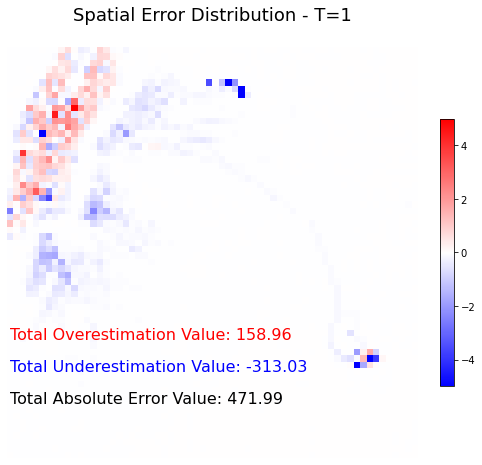

In [5]:
error_analysis(1)

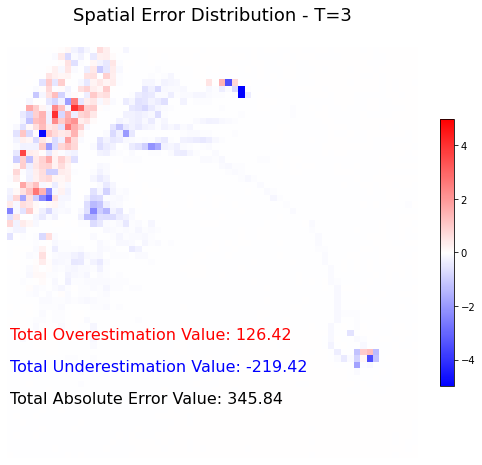

In [6]:
error_analysis(3)

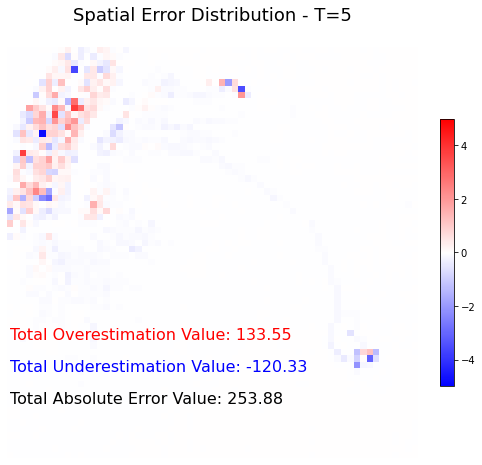

In [7]:
error_analysis(5)

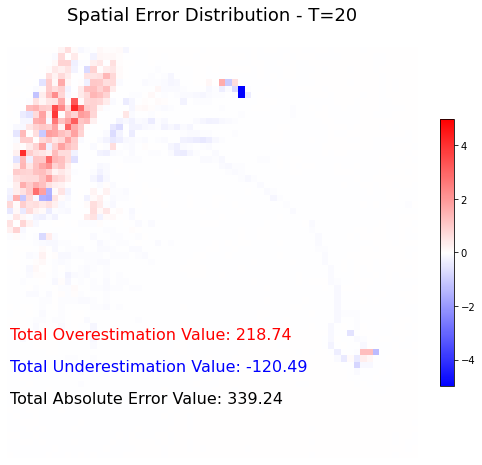

In [8]:
error_analysis(20)